### Step 1 : Include Libraries and Initialize Spark Session

In [8]:
#import libraries
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-streaming-kafka-0-10_2.12:3.0.0,org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.0 pyspark-shell'

#import libraries
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import Row, SparkSession

from pyspark.sql.functions import regexp_extract
import pyspark.sql.functions as F
from pyspark.sql.types import *

appName="StructuredStreamingKafka"
#initialize the spark session
spark = SparkSession.builder.appName(appName).getOrCreate()
spark.sparkContext.setLogLevel('ERROR')
#get sparkcontext from the sparksession
sc = spark.sparkContext

## Use-Case : Tracking Server Access Log <a class="anchor" name="use-case"></a>
For this case, a server is going to continuously send a records of a host who is trying to access some endpoint (url) from the web server. This data will be send from a kafka producer (<code>KafkaProducer1.ipynb</code>) which is reading the data from a txt file in the dataset provided (<code>logs/access_log.txt</code>).

Each line contains some valuable information such as:

1. Host
2. Timestamp
3. HTTP method
4. URL endpoint
5. Status code
6. Protocol
7. Content Size

The goal here is to perform some real time queries from this stream of data and be able to output the results in multiple ways.

### Load Kafka Stream 
Use the <code>readStream</code> to load data from the Kafka Producer <strong>LT1-KafkaProducer.ipynb</strong>

In [9]:
# Monitor the logs data stream for new log data
topic = "w11_access_log"
df_urls = spark \
  .readStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "127.0.0.1:9092") \
  .option("subscribe", topic) \
  .load()

## Data Preparation <a class="anchor" name="data-prep"></a>
We need to convert the data from the message in order to perform some queries. The steps to parse the data are:

1. Get message as a string from <code>value</code> which is binary.
2. Implement some regular expressions to capture specific fields in the message which is a line from the access log.
3. Extract the values using the regular expressions to create the dataframe.

In [10]:
# Get value of the kafka message
log_lines = df_urls.selectExpr("CAST(value AS STRING)")

# Parse out the common log format to a DataFrame
tsExp=r'(\d{10})\s'
statusExp = r'\s(\d{3})\s'
generalExp = r'\"(\S+)\s(\S+)\s*(\S*)\"'
hostExp = r'(\d+\.\d+\.\d+\.\d+)'

df_logs = log_lines.select(F.from_utc_timestamp(F.from_unixtime(regexp_extract('value', tsExp, 1)),'UTC').alias('ts'),
                         regexp_extract('value', hostExp, 1).alias('host'),
                         regexp_extract('value', generalExp, 1).alias('method'),
                         regexp_extract('value', generalExp, 2).alias('endpoint'),
                         regexp_extract('value', generalExp, 3).alias('protocol'),
                         regexp_extract('value', statusExp, 1).cast('integer').alias('status'))

df_logs.printSchema()

root
 |-- ts: timestamp (nullable = true)
 |-- host: string (nullable = true)
 |-- method: string (nullable = true)
 |-- endpoint: string (nullable = true)
 |-- protocol: string (nullable = true)
 |-- status: integer (nullable = true)



In [11]:
query = df_logs \
    .writeStream \
    .outputMode("append") \
    .format("console") \
    .trigger(processingTime='5 seconds') \
    .start()

In [12]:
query.stop()

## Aggregations on window over event-time  <a class="anchor" name="window"></a>

The event-time we use here is the <code>ts</code> that we have generated in the producer. 

<a class="anchor" id="lab-task-1"></a>
<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#FF5555">1. Lab Task: </strong> 
Using the Window function, find the number of logs for each status in a window of 30 seconds. Set the window sliding interval to 10 seconds. Write the output to console sink.
</div>

In [4]:
df = df_logs.withWatermark('ts', '10 second')\
            .groupby(F.window(df_logs.ts, '30 second'), df_logs.status)\
            .agg(F.count('ts').alias('count'))
df.printSchema()

root
 |-- window: struct (nullable = false)
 |    |-- start: timestamp (nullable = true)
 |    |-- end: timestamp (nullable = true)
 |-- status: integer (nullable = true)
 |-- count: long (nullable = false)



In [6]:
query = df.writeStream\
        .outputMode('complete')\
        .format('console')\
        .trigger(processingTime = '5 second')\
        .option('truncate', 'false').start()

In [7]:
query.stop()

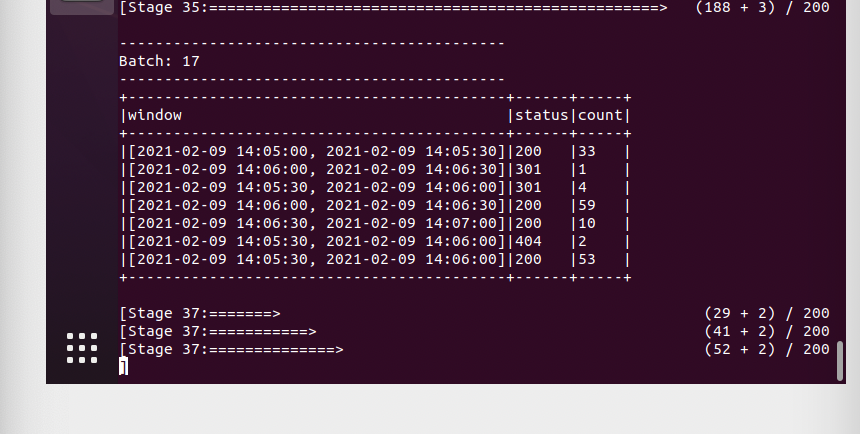